In [1]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

/home/aaryen/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# splitting data into test train and validation

subprocesses = 0 #num_workers
batch_size = 20
valid_size = 0.2 # 20% of training set is used for validation

# path to updated Oxford dataset
data_path = "/home/aaryen/Desktop/CGS402/Project 1/recaptcha_v2/dataset"

# augmenting and normalizing data
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.ToTensor(), transforms.Resize((120, 120)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get the entire dataset
data = datasets.ImageFolder(data_path, transform=transform)

# dividing into train and test
train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
train_num = len(train_dataset)
index = list(range(train_num))

np.random.shuffle(index)
split = int(np.floor(valid_size * train_num))
train_id, valid_id = index[split:], index[:split]

# getting train and validation sets
train = SubsetRandomSampler(train_id)
valid = SubsetRandomSampler(valid_id)

# prepare data loaders (combine dataset and sampler)
train_load = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train, num_workers=subprocesses)
valid_load = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid, num_workers=subprocesses)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=subprocesses, shuffle=True)

In [3]:
# image classes
classes = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Traffic Light']

In [4]:
def imshow(img):

    """
    De-normalizing the image and plotting it by transforming back to image from tensor
    """

    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

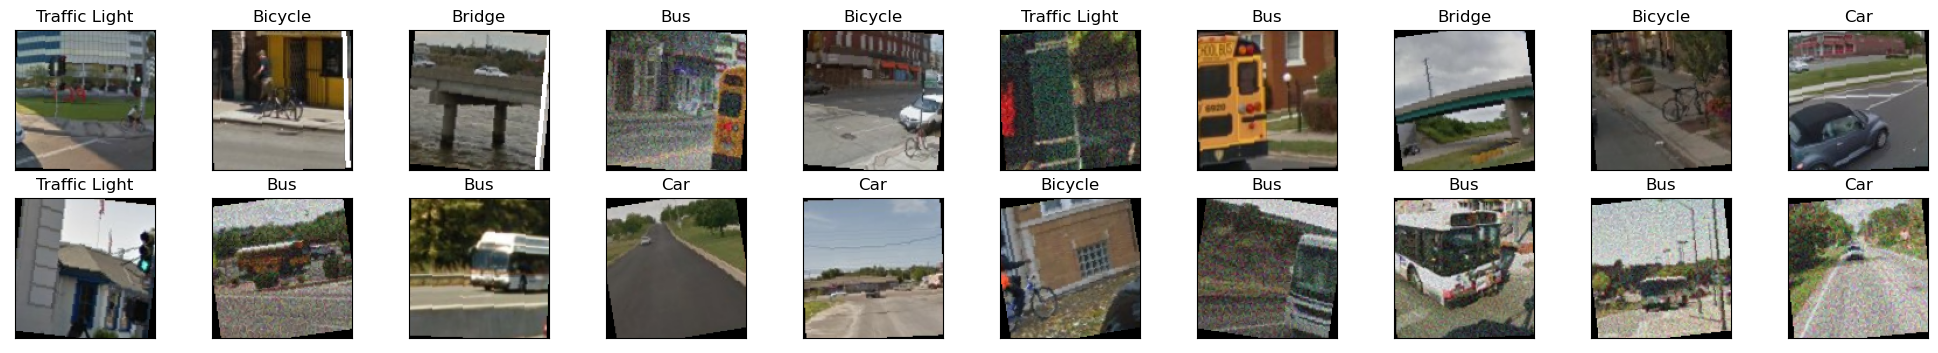

In [5]:
# visualizing train data

# getting one batch of train images
dataiter = iter(train_load)
images, labels = next(dataiter)
images = images.numpy()

# showing images with labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

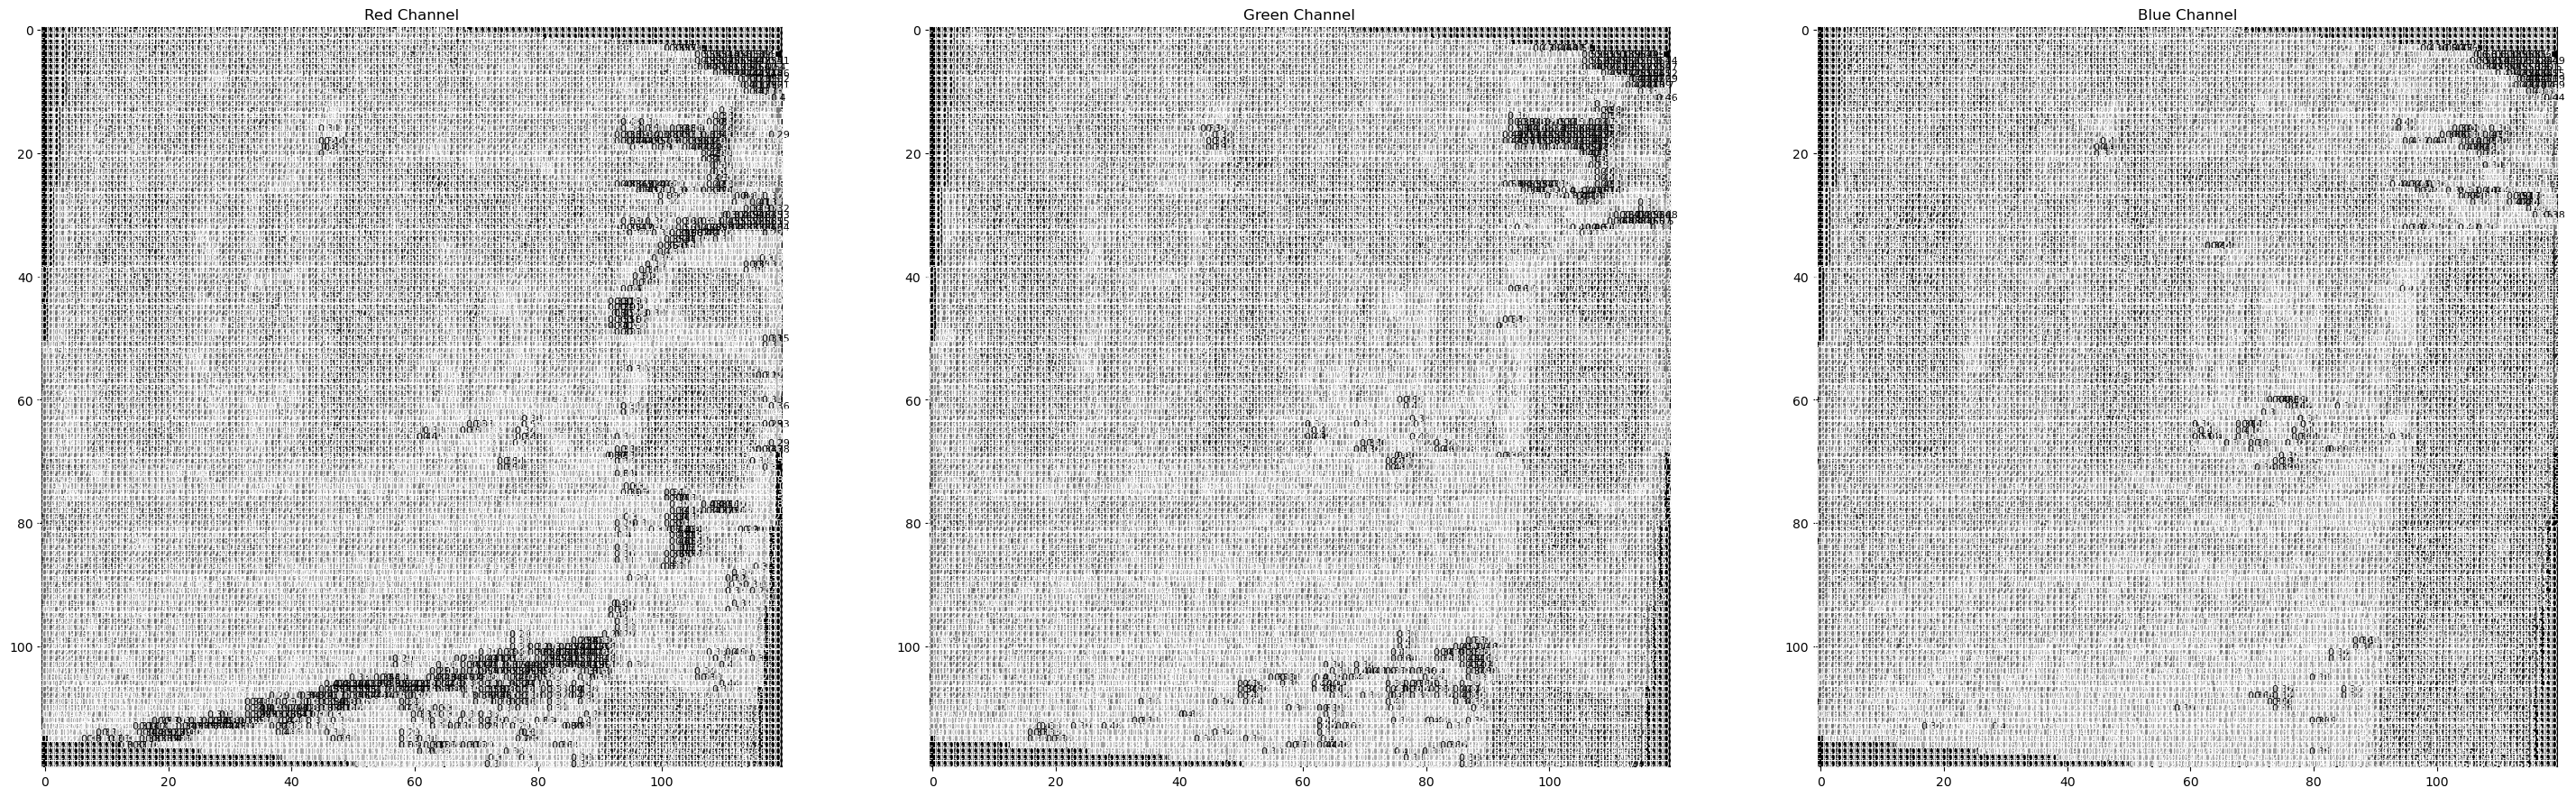

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['Red Channel', 'Green Channel', 'Blue Channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', size=8, color='white' if img[x][y]<thresh else 'black')

In [7]:
# use gpu if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# getting pre trained vgg16 model from torch library
model = models.vgg16(pretrained=True)

/home/aaryen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aaryen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# freezing parameters for quicker backpropagating
for param in model.parameters():
    param.requires_grad = False

# new classifier instead of 5 classes
model.classifier = nn.Sequential(nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), nn.Linear(4096, 1000), nn.ReLU(), nn.Dropout(0.5), nn.Linear(1000, 5))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

# moving model to device
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# training the model

epochs = 10 # number of epochs
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
     
    model.train()
    loop = tqdm(enumerate(train_load), total = len(train_load), position=0, leave=False)
    for batch_id, (data, target) in loop:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) # forward pass
        loss = criterion(output, target) # calculating batch loss
        loss.backward() # backward pass
        optimizer.step()
        train_loss += loss.item()*data.size(0)    
        loop.set_description(f"Epoch [{epoch}/{epochs}]") # showing progress
        loop.set_postfix(loss = loss.item())

    # validate the model 
    model.eval()
    for batch_id, (data, target) in enumerate(valid_load):
        data, target = data.to(device), target.to(device)
        output = model.forward(data) # forward pass
        loss = criterion(output, target) # calculating batch loss
        valid_loss += loss.item() * data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_load.sampler)
    valid_loss = valid_loss/len(valid_load.sampler)
        
    # training and validation statistics 
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch, train_loss, valid_loss))
    
    # update model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), "model_augmented.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.991289 	Validation Loss: 0.683972
Validation loss decreased (inf --> 0.683972).  Saving model ...


Epoch: 2 	Training Loss: 0.718102 	Validation Loss: 0.642246
Validation loss decreased (0.683972 --> 0.642246).  Saving model ...


Epoch: 3 	Training Loss: 0.641757 	Validation Loss: 0.712834


Epoch: 4 	Training Loss: 0.624189 	Validation Loss: 0.686780


Epoch: 5 	Training Loss: 0.591617 	Validation Loss: 0.706754


Epoch: 6 	Training Loss: 0.565750 	Validation Loss: 0.654577


Epoch: 7 	Training Loss: 0.524041 	Validation Loss: 0.584963
Validation loss decreased (0.642246 --> 0.584963).  Saving model ...


Epoch: 8 	Training Loss: 0.521846 	Validation Loss: 0.594894


Epoch: 9 	Training Loss: 0.510191 	Validation Loss: 0.645061


Epoch: 10 	Training Loss: 0.518296 	Validation Loss: 0.667992


In [12]:
# load model with lowest validation loss
model.load_state_dict(torch.load("model_augmented.pt"))

<All keys matched successfully>

In [13]:
# testing the model

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()

for batch_id, (data, target) in enumerate(test_load):
    data, target = data.to(device), target.to(device)
    output = model(data) # forward pass
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1) # updating probabilities 
    correct_tensor = pred.eq(target.data.view_as(pred)) # comparing predictions with actual value
    correct = np.squeeze(correct_tensor.numpy()) if not device == "cuda" else np.squeeze(correct_tensor.cpu().numpy())
    # test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item() 
        class_total[label] += 1 

# average test loss
test_loss = test_loss/len(test_load.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print("\nTest Accuracy (Overall): %2d%% (%2d/%2d)" % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.694423

Test Accuracy of Bicycle: 90% (63/70)
Test Accuracy of Bridge: 73% (36/49)
Test Accuracy of   Bus: 71% (77/108)
Test Accuracy of   Car: 79% (89/112)
Test Accuracy of Traffic Light: 87% (71/81)

Test Accuracy (Overall): 80% (336/420)


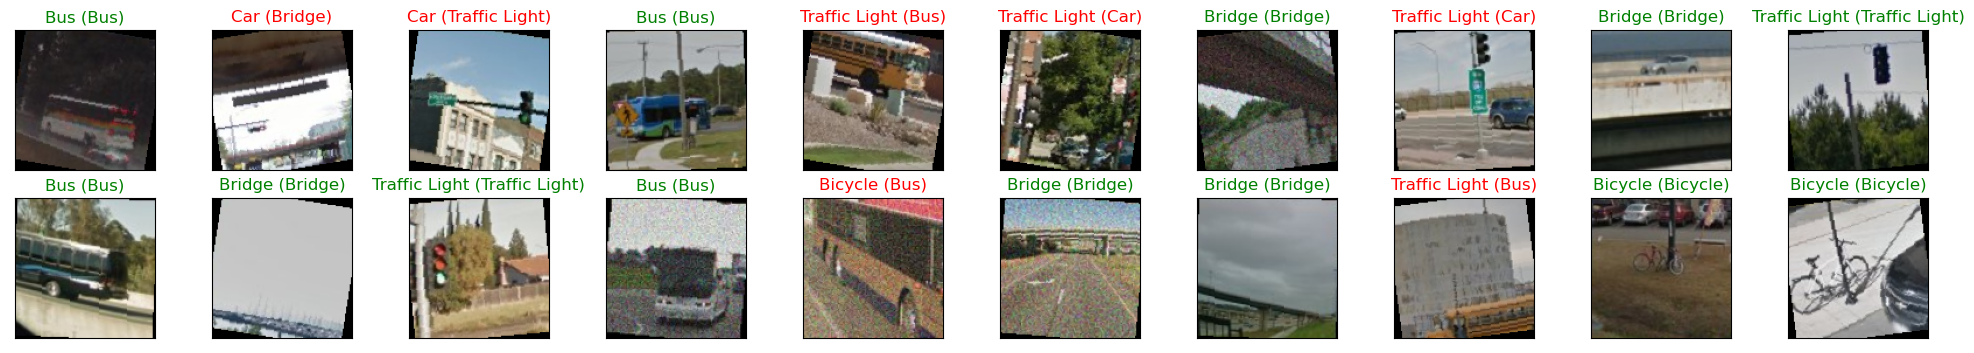

In [15]:
# visualizing test results

# obtain one batch of test images
dataiter = iter(test_load)
images, labels = next(dataiter)
images.numpy()
images = images.to(device)

output = model(images)
_, preds_tensor = torch.max(output, 1) # probabilities to class
preds = np.squeeze(preds_tensor.numpy()) if not device == "cuda" else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images with predicted and actual labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))